# Environment Perception For Self-Driving Cars
### This project consists of four modules:
1. Use the output of semantic segmentation to implement drivable space estimation in 3D.
2. Use the output of semantic segmentation to implement lane estimation.
3. Use the output of semantic segmentation to filter errors in the output of 2D object detectors.
4. Use the filtered 2D object detection results to determine how far obstacles are from the self-driving car.

In [1]:
# Loading packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m6bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
np.set_printoptions(precision=2, threshold=np.nan)

current_frame:  0
image


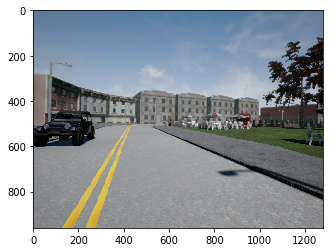

In [2]:
# Loading and Visualizing the Data
dataset_handler = DatasetHandler()
print("current_frame: ", dataset_handler.current_frame)
image = dataset_handler.image
print('image')
plt.imshow(image)

In [3]:
k = dataset_handler.k
print("Camera intrinsic matrix: \n", k)

Camera intrinsic matrix: 
 [[640   0 640]
 [  0 640 480]
 [  0   0   1]]


Depth map


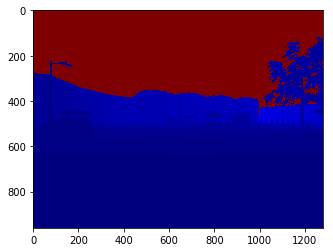

In [4]:
depth = dataset_handler.depth
print('Depth map')
plt.imshow(depth, cmap='jet')

Segmentation


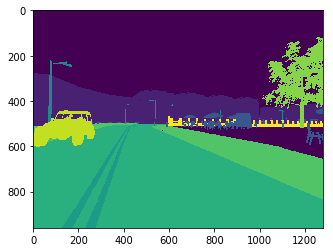

In [5]:
segmentation = dataset_handler.segmentation
print('Segmentation')
plt.imshow(segmentation)

## 1 - Drivable Space Estimation Using Semantic Segmentation Output
### 1.1 - Estimating the x, y, and z coordinates of every pixel in the image:

In [6]:
# GRADED FUNCTION: xy_from_depth
def xy_from_depth(depth, k):
    """
    Computes the x, and y coordinates of every pixel in the image using the depth map and the calibration matrix.

    Arguments:
    depth -- tensor of dimension (H, W), contains a depth value (in meters) for every pixel in the image.
    k -- tensor of dimension (3x3), the intrinsic camera matrix

    Returns:
    x -- tensor of dimension (H, W) containing the x coordinates of every pixel in the camera coordinate frame.
    y -- tensor of dimension (H, W) containing the y coordinates of every pixel in the camera coordinate frame.
    """
    ### START CODE HERE ### (≈ 7 lines in total)

    # Get the shape of the depth tensor
    h, w = depth.shape
    # Grab required parameters from the K matrix
    c_u, c_v, f = k[0][2], k[1][2], k[0][0]
    # Generate a grid of coordinates corresponding to the shape of the depth map
    grid_x = np.zeros((h, w))
    grid_y = np.zeros((h, w))
    for u in range(h):
        for v in range(w):
            grid_x[u][v] = (u - c_u) * depth[u][v] / f
            grid_y[u][v] = (v - c_v) * depth[u][v] / f
    # Compute x and y coordinates
    x = grid_x
    y = grid_y
    ### END CODE HERE ###
    
    return x, y

In [7]:
dataset_handler.set_frame(0)

k = dataset_handler.k

z = dataset_handler.depth

x, y = xy_from_depth(z, k)

print('x[800,800] = ' + str(x[800, 800]))
print('y[800,800] = ' + str(y[800, 800]))
print('z[800,800] = ' + str(z[800, 800]) + '\n')

print('x[500,500] = ' + str(x[500, 500]))
print('y[500,500] = ' + str(y[500, 500]))
print('z[500,500] = ' + str(z[500, 500]) + '\n')

x[800,800] = 0.716
y[800,800] = 1.432
z[800,800] = 2.864

x[500,500] = -9.64315625
y[500,500] = 1.37759375
z[500,500] = 44.083



### 1.2 - Estimating The Ground Plane Using RANSAC:

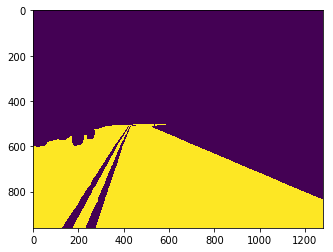

In [8]:
# Get road mask by choosing pixels in segmentation output with value 7
road_mask = np.zeros(segmentation.shape)
road_mask[segmentation == 7] = 1

# Show road mask
plt.imshow(road_mask)

# Get x,y, and z coordinates of pixels in road mask
x_ground = x[road_mask == 1]
y_ground = y[road_mask == 1]
z_ground = dataset_handler.depth[road_mask == 1]
xyz_ground = np.stack((x_ground, y_ground, z_ground))

In [9]:
# GRADED FUNCTION: RANSAC Plane Fitting

def ransac_plane_fit(xyz_data):
    """
    Computes plane coefficients a,b,c,d of the plane in the form ax+by+cz+d = 0
    using ransac for outlier rejection.

    Arguments:
    xyz_data -- tensor of dimension (3, N), contains all data points from which random sampling will proceed.
    num_itr -- 
    distance_threshold -- Distance threshold from plane for a point to be considered an inlier.

    Returns:
    p -- tensor of dimension (1, 4) containing the plane parameters a,b,c,d
    """
    
    ### START CODE HERE ### (≈ 23 lines in total)
    
    # Set thresholds:
    num_itr = 100  # RANSAC maximum number of iterations
    min_num_inliers = 50  # RANSAC minimum number of inliers
    distance_threshold = 0.1  # Maximum distance from point to plane for point to be considered inlier
    
    best_plane = np.ones((4, 1))
    for i in range(num_itr):
        # Step 1: Choose a minimum of 3 points from xyz_data at random.
        n = xyz_data.shape[1] 
        indexs = (np.random.randint(n), np.random.randint(n), np.random.randint(n))
        points = xyz_data[:, indexs]
        points_f = np.array([points[1], points[0], -points[2]])
        # Step 2: Compute plane model
        plane = compute_plane(points_f)
        # Step 3: Find number of inliers
        numer_of_inliers = 0
        max_num = 0
        best_point_index_store = []
        point_index_store = []
        for point_index in range(n):
            x = xyz_data[:, point_index][0]
            y = xyz_data[:, point_index][1]
            z = xyz_data[:, point_index][2]
#             print(x, y, z, plane)
            dis = dist_to_plane(plane, x, y, z)
            if dis <= distance_threshold:
                numer_of_inliers += 1
                point_index_store.append(point_index)
        if numer_of_inliers > max_num:
            best_plane = plane
            best_point_index_store = point_index_store
        # Step 4: Check if the current number of inliers is greater than all previous iterations and keep the inlier set with the largest number of points.
        
        # Step 5: Check if stopping criterion is satisfied and break.         
        if i >= num_itr or numer_of_inliers >= min_num_inliers:
            break
        
    # Step 6: Recompute the model parameters using largest inlier set.         
#     output_plane = compute_plane(xyz_data[:, best_point_index_store])
    output_plane = best_plane
    ### END CODE HERE ###
    
    return output_plane 

In [10]:
p_final = ransac_plane_fit(xyz_ground)
print('Ground Plane: ' + str(p_final))

Ground Plane: [ 0.02 -0.97  0.24  1.36]


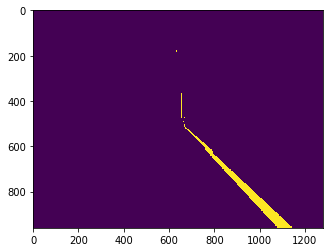

In [11]:
dist = np.abs(dist_to_plane(p_final, x, y, z))

ground_mask = np.zeros(dist.shape)

ground_mask[dist < 0.1] = 1
ground_mask[dist > 0.1] = 0

plt.imshow(ground_mask)

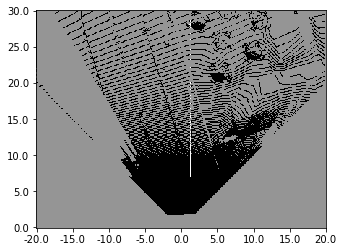

In [12]:
dataset_handler.plot_free_space(ground_mask)

## 2 - Lane Estimation Using The Semantic Segmentation Output
### 2.1 Estimating Lane Boundary Proposals:

In [13]:
# GRADED FUNCTION: estimate_lane_lines
def estimate_lane_lines(segmentation_output):
    """
    Estimates lines belonging to lane boundaries. Multiple lines could correspond to a single lane.

    Arguments:
    segmentation_output -- tensor of dimension (H,W), containing semantic segmentation neural network output
    minLineLength -- Scalar, the minimum line length
    maxLineGap -- Scalar, dimension (Nx1), containing the z coordinates of the points

    Returns:
    lines -- tensor of dimension (N, 4) containing lines in the form of [x_1, y_1, x_2, y_2], where [x_1,y_1] and [x_2,y_2] are
    the coordinates of two points on the line in the (u,v) image coordinate frame.
    """
    ### START CODE HERE ### (≈ 7 lines in total)
    # Step 1: Create an image with pixels belonging to lane boundary categories from the output of semantic segmentation
    img = (segmentation_output == 6) + (segmentation_output == 8)
    img = (img != 0)
    img_mask = np.stack([img, img, img], axis=2)
    image = dataset_handler.image * img_mask
    # Step 2: Perform Edge Detection using cv2.Canny()
    image = image.astype('uint8')
    edges = cv2.Canny(image, 10, 400)
    # Step 3: Perform Line estimation using cv2.HoughLinesP()
    lines = cv2.HoughLinesP(edges,1,np.pi/180,100,200,10)
    lines = lines.reshape(-1, 4)
    # Note: Make sure dimensions of returned lines is (N x 4)
    ### END CODE HERE ###

    return lines

(40, 4)


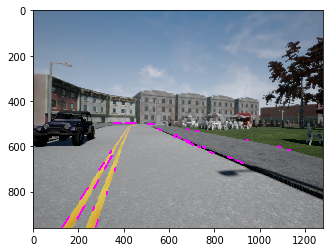

In [14]:
lane_lines = estimate_lane_lines(segmentation)

print(lane_lines.shape)

plt.imshow(dataset_handler.vis_lanes(lane_lines))

## 3 - Computing Minimum Distance To Impact Using The Output of 2D Object Detection.
### 3.1 - Filtering Out Unreliable Detections:

In [15]:
# Graded Function: filter_detections_by_segmentation
def filter_detections_by_segmentation(detections, segmentation_output):
    """
    Filter 2D detection output based on a semantic segmentation map.

    Arguments:
    detections -- tensor of dimension (N, 5) containing detections in the form of [Class, x_min, y_min, x_max, y_max, score].
    
    segmentation_output -- tensor of dimension (HxW) containing pixel category labels.
    
    Returns:
    filtered_detections -- tensor of dimension (N, 5) containing detections in the form of [Class, x_min, y_min, x_max, y_max, score].

    """
    ### START CODE HERE ### (≈ 20 lines in total)
    filtered_detections = []
    # Set ratio threshold:
    ratio_threshold = 0.3  # If 1/3 of the total pixels belong to the target category, the detection is correct.
    
    for detection in detections:
        
        # Step 1: Compute number of pixels belonging to the category for every detection.
        score = np.unique(segmentation[int(float(detection[2])):int(float(detection[4])), int(float(detection[1])):int(float(detection[3]))], \
          return_counts=True)[1][-1] / ((int(float(detection[4])) - int(float(detection[2]))) * (int(float(detection[3])) - int(float(detection[1]))))
        # Step 2: Devide the computed number of pixels by the area of the bounding box (total number of pixels).
        if score > ratio_threshold:
            filtered_detections.append(detection)
        # Step 3: If the ratio is greater than a threshold keep the detection. Else, remove the detection from the list of detections.

 
    ### END CODE HERE ###
    
    return filtered_detections

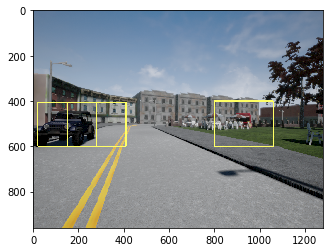

In [16]:
detections = dataset_handler.object_detection
plt.imshow(dataset_handler.vis_object_detection(detections))

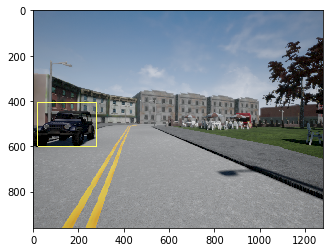

In [17]:
filtered_detections = filter_detections_by_segmentation(detections, segmentation)
plt.imshow(dataset_handler.vis_object_detection(filtered_detections))

### 3.2 - Estimating Minimum Distance To Impact:

In [18]:
# Graded Function: find_min_distance_to_detection:
def find_min_distance_to_detection(detections, x, y, z):
    """
    Filter 2D detection output based on a semantic segmentation map.

    Arguments:
    detections -- tensor of dimension (N, 5) containing detections in the form of [Class, x_min, y_min, x_max, y_max, score].
    
    x -- tensor of dimension (H, W) containing the x coordinates of every pixel in the camera coordinate frame.
    y -- tensor of dimension (H, W) containing the y coordinates of every pixel in the camera coordinate frame.
    z -- tensor of dimensions (H,W) containing the z coordinates of every pixel in the camera coordinate frame.
    Returns:
    min_distances -- tensor of dimension (N, 1) containing distance to impact with every object in the scene.

    """
    ### START CODE HERE ### (≈ 20 lines in total)
    distances = []
    for detection in detections:
        # Step 1: Compute distance of every pixel in the detection bounds
        for x_ in range(int(float(filtered_detections[0][2])), int(float(filtered_detections[0][4]))):
            for y_ in range(int(float(filtered_detections[0][1])), int(float(filtered_detections[0][3]))):
                distances.append(np.sqrt(x[x_, y_]**2 + y[x_, y_]**2 + z[x_, y_]**2)) 
        # Step 2: Find minimum distance
    min_distances = [np.min(distances)]
    ### END CODE HERE ###
    return min_distances

In [19]:
min_distances = find_min_distance_to_detection(filtered_detections, x, y, z)
print('Minimum distance to impact is: ' + str(min_distances))

Minimum distance to impact is: [7.688815317163321]


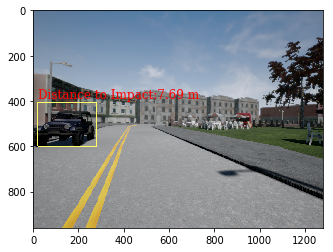

In [20]:
font = {'family': 'serif','color': 'red','weight': 'normal','size': 12}

im_out = dataset_handler.vis_object_detection(filtered_detections)

for detection, min_distance in zip(filtered_detections, min_distances):
    bounding_box = np.asfarray(detection[1:5])
    plt.text(bounding_box[0], bounding_box[1] - 20, 'Distance to Impact:' + str(np.round(min_distance, 2)) + ' m', fontdict=font)

plt.imshow(im_out)